# Model Optimization

In [1]:
from datetime import datetime

import numpy as np
import pandas as pd
from IPython.display import display

import ml_utils as mu
from sklearn import metrics as metrics

from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_selection import SelectKBest, f_classif

import itertools
import matplotlib.pyplot as plt


def do_grid_search(mod_clf, mod_name, params, group, cv=5, scoring='accuracy', variant=None):
#     params['kbest__k'] = [1,3,5,7,10,15,20,25,30,37]#np.linspace(1,X.shape[1],10, dtype = int)
#     params['pca__n_components'] = np.linspace(1,10,10, dtype = int)
    clf = Pipeline([
        ('standardization', StandardScaler()),
#         ('pca', PCA()),
        ('oversampler', RandomOverSampler()),
#         ('kbest', SelectKBest(score_func=f_classif)),
        ('classifier', mod_clf)
    ])
#     with mu.Timer('Hyperparameter Grid Search for %s' %mod_name):
    best = mu.grid_search_optimization(clf, params, X, y, Xh, yh, Xv, yv, cv=cv, scoring=scoring)
    accuracy = {
        "model" : mod_name, 
        "mean_cv_acc" : best.best_estimator_.score(X,y),
        "holdout_acc" : best.best_estimator_.score(Xh,yh),
        "validation_acc" : best.best_estimator_.score(Xv,yv),
        "date_modified" : datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "best_params" : str(best.best_params_),
        "variant" : variant,
        "cv": cv
    }

    yh_pred = best.best_estimator_.predict(Xh)
    cnf_matrix=metrics.confusion_matrix(yh, yh_pred)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, normalize=True,classes=group['description'].split(' vs. '), title="%s: %s (Holdout)"%(group['description'], mod_name))
    print("HOLDOUT ACCURACY: %.3f" %best.best_estimator_.score(Xh,yh))

    yv_pred = best.best_estimator_.predict(Xv)
    cnf_matrix=metrics.confusion_matrix(yv, yv_pred)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, normalize=True,classes=group['description'].split(' vs. '), title="%s: %s (Validation)"%(group['description'], mod_name))
    print("VALIDATION ACCURACY: %.3f" %best.best_estimator_.score(Xv,yv))
    print()
        
    return accuracy

def getOptimizedModel(model_name, optim_params):
    models = {model['name']: model for model in mu.get_baseline_models()}
    model = models[model_name]['model']
    
    clf = Pipeline([
        ('standardization', StandardScaler()),
        ('oversampler', RandomOverSampler()),
        ('kbest', SelectKBest(score_func=f_classif)),
        ('classifier', model)
    ])
    clf.set_params(**optim_params)
    return clf

def getData(data_file):
    try:
        return pd.read_csv(data_file, index_col=0)
    except:
        pass
    return pd.DataFrame()

def addData(new_data, data_file, save=True):
    df = getData(data_file = data_file)
    df = df.append(new_data, ignore_index=True)
    if save:
        saveData(df, data_file = data_file)
    return df
    
def saveData(df, data_file):
    df[['model', 'mean_cv_acc', 'holdout_acc', 'validation_acc', 'cv', 'best_params', 'date_modified', 'variant']].to_csv(data_file)
    
def showData(df, name):
    if name:
        display(df.loc[df.model == name].set_index('model')[['mean_cv_acc', 'holdout_acc', 'validation_acc', 'date_modified', 'variant']])
    else:
        display(df.set_index('model')[['mean_cv_acc', 'holdout_acc', 'validation_acc', 'date_modified', 'variant']])
            
def delete_row(data_file, index = None, last=False):
    if not (index or last):
        return
    df = getData(data_file = data_file)
    if last:
        df = df.drop(df.index[len(df)-1])
    if index:
        df = df.drop(index)
    saveData(df, data_file = data_file)
    return df

def plot_results(title, data_file, plot_file, variant=None):
    %matplotlib inline
    
    if variant:
        d = getData(data_file = data_file).loc[df.variant == variant].groupby('model').first()
    else:
        d = getData(data_file = data_file).loc[df.variant.isnull()].groupby('model').first()

    if variant:
        title = '%s (%s)' %(title, variant)
    
    ax = d.drop(['cv'], axis=1).plot(kind='bar', figsize=(10,6), rot=0)
    ax.set_xlabel('Model')
    ax.set_ylabel('Accuracy')
    ax.set_ybound((0,1.1))
    ax.set_title(title)
    l = ax.legend(labels=['cross-val accuracy','holdout accuracy', 'validation accuracy'])
    fig = ax.get_figure()
    fig.savefig('images/%s'%plot_file)

    plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

====
====
====                         Starting MSA vs. PSP
====                                      10FOLDMCC
====
====
# Tuning hyper-parameters for make_scorer(matthews_corrcoef)

Fitting 10 folds for each of 600 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:  7.3min finished


Best parameters set found on development set:

{'classifier__learning_rate': 0.048939009184774937, 'classifier__n_estimators': 341}

Grid scores on development set:

0.087 (+/-0.600) for {'classifier__learning_rate': 0.0001, 'classifier__n_estimators': 1}
0.046 (+/-0.466) for {'classifier__learning_rate': 0.0001, 'classifier__n_estimators': 21}
0.113 (+/-0.624) for {'classifier__learning_rate': 0.0001, 'classifier__n_estimators': 41}
0.152 (+/-0.594) for {'classifier__learning_rate': 0.0001, 'classifier__n_estimators': 61}
0.107 (+/-0.630) for {'classifier__learning_rate': 0.0001, 'classifier__n_estimators': 81}
0.151 (+/-0.570) for {'classifier__learning_rate': 0.0001, 'classifier__n_estimators': 101}
0.177 (+/-0.627) for {'classifier__learning_rate': 0.0001, 'classifier__n_estimators': 121}
0.096 (+/-0.623) for {'classifier__learning_rate': 0.0001, 'classifier__n_estimators': 141}
0.085 (+/-0.587) for {'classifier__learning_rate': 0.0001, 'classifier__n_estimators': 161}
0.168 (+/-0.

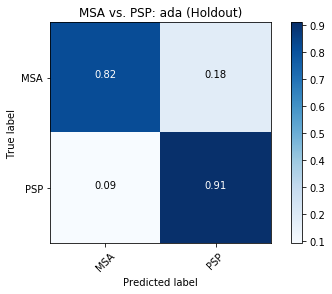

HOLDOUT ACCURACY: 0.864


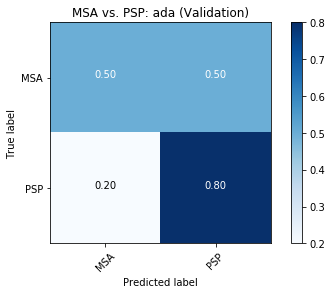

VALIDATION ACCURACY: 0.696



,mean_cv_acc,holdout_acc,validation_acc,date_modified,variant
model,,,,,
ada,0.823529,0.863636,0.812500,2018-07-14 21:27:36,NaN
ada,1.000000,0.772727,0.562500,2018-07-14 23:08:11,NaN
ada,0.741176,0.636364,0.750000,2018-07-15 11:34:38,FSS
ada,0.823529,0.727273,0.700000,2018-07-18 01:38:02,V3
ada,0.741176,0.636364,0.733333,2018-07-18 01:52:35,FSSV3
ada,0.811765,0.727273,0.750000,2018-07-25 12:41:00,2FOLDMCC
ada,1.000000,0.863636,0.625000,2018-07-25 12:57:30,10FOLDMCC
ada,1.000000,0.863636,0.739130,2018-07-25 13:15:29,10FOLDMCC
ada,1.000000,0.818182,0.695652,2018-07-25 14:53:19,10FOLDMCC


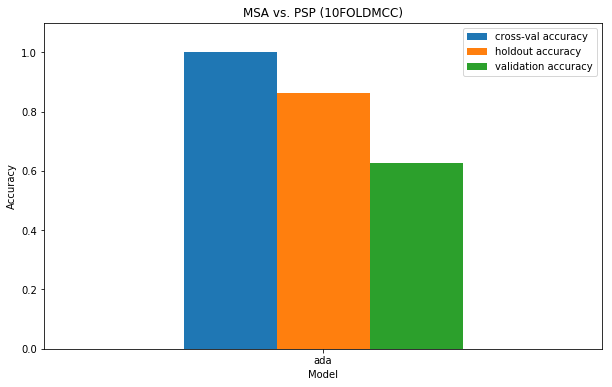

In [2]:
import ml_utils as mu
import matplotlib.pyplot as plt

cv = 10
variant = '10FOLDMCC'

groupings = [
#     {'name': 'cvp', 'grouping':{0:0, 1:1, 2:1, 3:1}, 'description':'Control vs. All Parkinsons'},
#     {'name': 'iva', 'grouping':{1:1, 2:2, 3:2},'description':'Idiopathic vs. Atypical Parkinsons'},
    {'name': 'mvp', 'grouping':{2:2, 3:3},'description':'MSA vs. PSP'}
]

mods = mu.get_baseline_models()
# mods = [x for x in mods if x['name'] not in ['svc_rbf']]
mods = [x for x in mods if x['name'] in ['ada']]

for grouping in groupings:
    print("===================================================================================")
    print("====")
    print("====")
    print("====                         Starting %s" %grouping['description'])
    if variant: print("====                                      %s" %variant)
    print("====")
    print("====")
    print("===================================================================================")
    with mu.HiddenPrints():
        X, y , Xh, yh, Xv, yv = mu.get_training_holdout_validation_data(grouping['grouping'], resample=False, use_v3=True)

    results_file = 'gridCV_%s.csv'%(grouping['name'])
    if variant:
        plot_file = '%s_%s_accuracy.png' %(results_file.split('.')[0], variant)
    else:
        plot_file = '%s_accuracy.png' %(results_file.split('.')[0])
    
    for m in mods:
        mod_clf = m['model']
        mod_name = m['name']
        params = m['params']

        if mod_name == 'knn':
            params['classifier__n_neighbors'] = np.linspace(5,round((1 - 1.0/cv)*len(y) - 5),10, dtype = int)
        
        accuracy = do_grid_search(mod_clf, mod_name, params, cv=cv, variant=variant, scoring=metrics.make_scorer(metrics.matthews_corrcoef), group=grouping)
        df = addData(accuracy, data_file = results_file)
        showData(df, mod_name)

    plot_results(title=grouping['description'], data_file=results_file, plot_file=plot_file, variant=variant)

In [12]:
# This code creates a model using the best parameters and creates a new table row for each model using the new 3.0 Validation Data

groupings = [
    {'name': 'cvp', 'grouping':{0:0, 1:1, 2:1, 3:1}, 'description':'Control vs. All Parkinsons', 'data_file':'gridCV_cvp.csv'},
    {'name': 'iva', 'grouping':{1:1, 2:2, 3:2},'description':'Idiopathic vs. Atypical Parkinsons', 'data_file':'gridCV_iva.csv'},
    {'name': 'mvp', 'grouping':{2:2, 3:3},'description':'MSA vs. PSP', 'data_file':'gridCV_mvp.csv'}
]

for grouping in groupings:
    with mu.HiddenPrints():
        X, y , Xh, yh, Xv, yv = mu.get_training_holdout_validation_data(grouping['grouping'], use_v3=True)
    
    df = getData(data_file=grouping['data_file'])
    
    for index, row in df.loc[df.variant.isnull()].groupby('model').first().iterrows():
#         print("%10s %10f %10f"%(row.name, row.holdout_acc, row.validation_acc))
        mod = getOptimizedModel(row.name,eval(row.best_params))
        mod.fit(X,y)
        row.holdout_acc = mod.score(Xh,yh)
        row.validation_acc = mod.score(Xv,yv)
        row.date_modified = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        row.variant = 'V3'
        row['model'] = row.name
#         print("%10s %10f %10f"%(row.name, row.holdout_acc, row.validation_acc))
        df = df.append(row, ignore_index=True)

#     saveData(df, grouping['data_file'])
    display(df)

,model,mean_cv_acc,holdout_acc,validation_acc,cv,best_params,date_modified,variant
0,knn,1.000000,0.750000,0.829545,2.0,"{'classifier__n_neighbors': 60, 'classifier__p...",2018-07-14 19:24:35,NaN
1,svc_lin,0.969799,0.911765,0.977273,2.0,{'classifier__C': 1.9952623149688795},2018-07-14 19:24:43,NaN
2,svc_rbf,0.963087,0.897059,0.977273,2.0,"{'classifier__C': 1291549.6650148828, 'classif...",2018-07-14 19:24:55,NaN
3,rand_for,0.971477,0.911765,0.988636,2.0,"{'classifier__min_samples_leaf': 1, 'classifie...",2018-07-14 19:25:49,NaN
4,ada,0.944631,0.906863,0.988636,2.0,{'classifier__learning_rate': 0.01487352107293...,2018-07-14 19:26:33,NaN
5,gnb,0.845638,0.794118,0.943182,2.0,{'classifier__priors': None},2018-07-14 19:26:35,NaN
6,log,0.963087,0.911765,0.988636,2.0,"{'classifier__C': 1.0, 'classifier__penalty': ...",2018-07-14 19:26:44,NaN
7,ann,1.000000,0.931373,0.988636,2.0,"{'classifier__activation': 'tanh', 'classifier...",2018-07-14 19:41:32,NaN
8,xgboost,1.000000,0.926471,0.988636,2.0,"{'classifier__gamma': 0.017782794100389229, 'c...",2018-07-14 19:41:47,NaN
9,knn,0.946309,0.887255,0.795455,2.0,"{'classifier__n_neighbors': 5, 'classifier__p'...",2018-07-14 23:45:50,FSS


C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


,model,mean_cv_acc,holdout_acc,validation_acc,cv,best_params,date_modified,variant
0,knn,0.898515,0.80625,0.859375,2.0,"{'classifier__n_neighbors': 60, 'classifier__p...",2018-07-14 19:42:10,NaN
1,svc_lin,0.891089,0.79375,0.828125,2.0,{'classifier__C': 1.9952623149688795},2018-07-14 19:42:20,NaN
2,svc_rbf,0.900990,0.78125,0.921875,2.0,"{'classifier__C': 0.27825594022071259, 'classi...",2018-07-14 19:42:30,NaN
3,rand_for,0.995050,0.80000,0.875000,2.0,"{'classifier__min_samples_leaf': 1, 'classifie...",2018-07-14 19:43:21,NaN
4,ada,0.918317,0.80625,0.968750,2.0,{'classifier__learning_rate': 0.01487352107293...,2018-07-14 19:44:01,NaN
5,gnb,0.878713,0.80625,0.937500,2.0,{'classifier__priors': None},2018-07-14 19:44:03,NaN
6,log,0.896040,0.83750,0.859375,2.0,"{'classifier__C': 1.6102620275609394, 'classif...",2018-07-14 19:44:12,NaN
7,ann,0.950495,0.86875,0.859375,2.0,"{'classifier__activation': 'relu', 'classifier...",2018-07-14 19:59:19,NaN
8,xgboost,1.000000,0.78125,0.937500,2.0,"{'classifier__gamma': 0.031622776601683791, 'c...",2018-07-14 19:59:33,NaN
9,knn,0.913366,0.73750,0.812500,2.0,"{'classifier__n_neighbors': 26, 'classifier__p...",2018-07-14 23:47:09,FSS


C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


,model,mean_cv_acc,holdout_acc,validation_acc,cv,best_params,date_modified,variant
0,knn,0.823529,0.818182,0.687500,2.0,"{'classifier__n_neighbors': 8, 'classifier__p'...",2018-07-14 21:26:17,NaN
1,svc_lin,0.976471,0.681818,0.812500,2.0,{'classifier__C': 1.0},2018-07-14 21:26:24,NaN
2,svc_rbf,0.823529,0.818182,0.750000,2.0,"{'classifier__C': 0.0016681005372000592, 'clas...",2018-07-14 21:26:32,NaN
3,rand_for,1.000000,0.954545,0.750000,2.0,"{'classifier__min_samples_leaf': 1, 'classifie...",2018-07-14 21:27:09,NaN
4,ada,0.823529,0.863636,0.812500,2.0,{'classifier__learning_rate': 0.00280721620394...,2018-07-14 21:27:36,NaN
5,gnb,0.858824,0.818182,0.750000,2.0,{'classifier__priors': None},2018-07-14 21:27:38,NaN
6,log,0.952941,0.818182,0.812500,2.0,"{'classifier__C': 1.0, 'classifier__penalty': ...",2018-07-14 21:27:46,NaN
7,ann,0.941176,0.772727,0.750000,2.0,"{'classifier__activation': 'tanh', 'classifier...",2018-07-14 21:32:23,NaN
8,xgboost,1.000000,0.545455,0.687500,2.0,"{'classifier__gamma': 0.01, 'classifier__learn...",2018-07-14 21:32:32,NaN
9,knn,0.823529,0.818182,0.812500,2.0,"{'classifier__n_neighbors': 8, 'classifier__p'...",2018-07-14 23:06:53,NaN


In [95]:
# This code creates an ensemble voting model using all 8 base models with optimized parameters
from scipy import stats

groupings = [
    {'name': 'cvp', 'grouping':{0:0, 1:1, 2:1, 3:1}, 'description':'Control vs. All Parkinsons', 'data_file':'gridCV_cvp.csv'},
    {'name': 'iva', 'grouping':{1:1, 2:2, 3:2},'description':'Idiopathic vs. Atypical Parkinsons', 'data_file':'gridCV_iva.csv'},
    {'name': 'mvp', 'grouping':{2:2, 3:3},'description':'MSA vs. PSP', 'data_file':'gridCV_mvp.csv'}
]

for grouping in groupings[:]:
    with mu.HiddenPrints():
        X, y , Xh, yh, Xv, yv = mu.get_training_holdout_validation_data(grouping['grouping'], use_v3=True)
    
    df = getData(data_file=grouping['data_file'])
    
    models = []
    for index, row in df.loc[df.variant.isnull()].groupby('model').first().iterrows():
        mod = getOptimizedModel(row.name,eval(row.best_params))
        mod.fit(X,y)
        models.append(mod)
        
    # determine holdout accuracy
    acc = []
    for i in range(len(Xh)):
        preds =[]
        for m in models:
            preds.append(m.predict(Xh[i].reshape(1, -1))[0])
        pred = stats.mode(preds).mode[0]
        acc.append(1 if pred == yh[i] else 0)
    print(np.mean(acc))
    
    # determine validation accuracy
    acc = []
    for i in range(len(Xv)):
        preds =[]
        for m in models:
            preds.append(m.predict(Xv[i].reshape(1, -1))[0])
        pred = stats.mode(preds).mode[0]
        acc.append(1 if pred == yv[i] else 0)
    print(np.mean(acc))

    display(df.loc[df.variant.isnull()].groupby('model').first())

0.911764705882
0.958333333333


,mean_cv_acc,holdout_acc,validation_acc,cv,best_params,date_modified,variant
model,,,,,,,
ada,0.944631,0.906863,0.988636,2.0,{'classifier__learning_rate': 0.01487352107293...,2018-07-14 19:26:33,NaN
ann,1.000000,0.931373,0.988636,2.0,"{'classifier__activation': 'tanh', 'classifier...",2018-07-14 19:41:32,NaN
gnb,0.845638,0.794118,0.943182,2.0,{'classifier__priors': None},2018-07-14 19:26:35,NaN
knn,1.000000,0.750000,0.829545,2.0,"{'classifier__n_neighbors': 60, 'classifier__p...",2018-07-14 19:24:35,NaN
log,0.963087,0.911765,0.988636,2.0,"{'classifier__C': 1.0, 'classifier__penalty': ...",2018-07-14 19:26:44,NaN
rand_for,0.971477,0.911765,0.988636,2.0,"{'classifier__min_samples_leaf': 1, 'classifie...",2018-07-14 19:25:49,NaN
svc_lin,0.969799,0.911765,0.977273,2.0,{'classifier__C': 1.9952623149688795},2018-07-14 19:24:43,NaN
svc_rbf,0.963087,0.897059,0.977273,2.0,"{'classifier__C': 1291549.6650148828, 'classif...",2018-07-14 19:24:55,NaN
xgboost,1.000000,0.926471,0.988636,2.0,"{'classifier__gamma': 0.017782794100389229, 'c...",2018-07-14 19:41:47,NaN


C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.79375
0.837837837838


,mean_cv_acc,holdout_acc,validation_acc,cv,best_params,date_modified,variant
model,,,,,,,
ada,0.918317,0.80625,0.968750,2.0,{'classifier__learning_rate': 0.01487352107293...,2018-07-14 19:44:01,NaN
ann,0.950495,0.86875,0.859375,2.0,"{'classifier__activation': 'relu', 'classifier...",2018-07-14 19:59:19,NaN
gnb,0.878713,0.80625,0.937500,2.0,{'classifier__priors': None},2018-07-14 19:44:03,NaN
knn,0.898515,0.80625,0.859375,2.0,"{'classifier__n_neighbors': 60, 'classifier__p...",2018-07-14 19:42:10,NaN
log,0.896040,0.83750,0.859375,2.0,"{'classifier__C': 1.6102620275609394, 'classif...",2018-07-14 19:44:12,NaN
rand_for,0.995050,0.80000,0.875000,2.0,"{'classifier__min_samples_leaf': 1, 'classifie...",2018-07-14 19:43:21,NaN
svc_lin,0.891089,0.79375,0.828125,2.0,{'classifier__C': 1.9952623149688795},2018-07-14 19:42:20,NaN
svc_rbf,0.900990,0.78125,0.921875,2.0,"{'classifier__C': 0.27825594022071259, 'classi...",2018-07-14 19:42:30,NaN
xgboost,1.000000,0.78125,0.937500,2.0,"{'classifier__gamma': 0.031622776601683791, 'c...",2018-07-14 19:59:33,NaN


C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.818181818182
0.733333333333


,mean_cv_acc,holdout_acc,validation_acc,cv,best_params,date_modified,variant
model,,,,,,,
ada,0.823529,0.863636,0.8125,2.0,{'classifier__learning_rate': 0.00280721620394...,2018-07-14 21:27:36,NaN
ann,0.941176,0.772727,0.7500,2.0,"{'classifier__activation': 'tanh', 'classifier...",2018-07-14 21:32:23,NaN
gnb,0.858824,0.818182,0.7500,2.0,{'classifier__priors': None},2018-07-14 21:27:38,NaN
knn,0.823529,0.818182,0.6875,2.0,"{'classifier__n_neighbors': 8, 'classifier__p'...",2018-07-14 21:26:17,NaN
log,0.952941,0.818182,0.8125,2.0,"{'classifier__C': 1.0, 'classifier__penalty': ...",2018-07-14 21:27:46,NaN
rand_for,1.000000,0.954545,0.7500,2.0,"{'classifier__min_samples_leaf': 1, 'classifie...",2018-07-14 21:27:09,NaN
svc_lin,0.976471,0.681818,0.8125,2.0,{'classifier__C': 1.0},2018-07-14 21:26:24,NaN
svc_rbf,0.823529,0.818182,0.7500,2.0,"{'classifier__C': 0.0016681005372000592, 'clas...",2018-07-14 21:26:32,NaN
xgboost,1.000000,0.545455,0.6875,2.0,"{'classifier__gamma': 0.01, 'classifier__learn...",2018-07-14 21:32:32,NaN
